## [1. Importing Needed Modules](#import) ##
## [2. Reading Images and Creating a Dataframe of Image Paths and Class Labels](#makedf) ## 
## [3. Triming train_df so each class has 500 image samples](#trim) ##
## [4. Creating a custom Keras callback to continue or halt training](#callback) ##
## [5. Creating train, test and validation generators](#generators) ##
## [6. Creating a function to show Training Image Samples](#show) ##
## [7. Creating the Model](#model) ##  
## [8. Training the Model](#train) ##
## [9. Defining a function to plot the training data](#plot) ##
## [11. Making predictions on test set, creating Confusion Matrix and Classification Report](#result) ##
## [12. Saving the Model](#save) ##
## [13. Model Application Test](#single) ##



<a id="import"></a>
# <center>Importing Needed Modules</center>

In [1]:
import numpy as np
import pandas as pd
import os

# Suppress TensorFlow logging (1 = errors, 2 = warnings, 3 = info)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import time
import matplotlib.pyplot as plt
import cv2
import seaborn as sns

# Set Seaborn style for plots
sns.set_style('darkgrid')

import shutil
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# TensorFlow and Keras imports
import tensorflow as tf
tf.keras.backend.clear_session()
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation, Dropout, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

# Disable SSL verification for TensorFlow Hub
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# Explanation of the imports:
# - numpy and pandas are used for numerical computations and data manipulation.
# - os is used to set environment variables.
# - time is used to handle time-related tasks.
# - matplotlib and seaborn are used for plotting.
# - cv2 (OpenCV) is used for image processing.
# - sklearn is used for machine learning utilities such as splitting data and evaluating models.
# - tensorflow and tensorflow_hub are used for building and training neural networks.
# - keras is the high-level API of TensorFlow, used here for building the model.
# - ssl is used to handle SSL certificates, here to disable verification for TensorFlow Hub downloads.

# Confirm that all imports were successful
print("All modules imported successfully!")

All modules imported successfully!


<a id="makedf"></a>
# <center>Reading Images and Creating a Dataframe of Image Paths and Class Labels</center>

In [2]:
# Define paths to datasets
train_path = r'../input/knee-osteoarthritis-dataset-with-severity/train'
test_path = r'../input/knee-osteoarthritis-dataset-with-severity/test'
valid_path = r'../input/knee-osteoarthritis-dataset-with-severity/val'

# List of class names
list_of_classes = ['Healthy', 'Doubtful', 'Minimal', 'Moderate', 'Severe']

# Function to create DataFrame from directory path
def create_dataframe_from_directory(directory, list_of_classes, **kwargs):
    filepaths = []
    labels = []
    classlist = os.listdir(directory)
    
    for klass in classlist:
        intklass = int(klass)
        label = list_of_classes[intklass]
        classpath = os.path.join(directory, klass)
        flist = os.listdir(classpath)
        
        for f in flist:
            fpath = os.path.join(classpath, f)
            filepaths.append(fpath)
            labels.append(label)
    
    # Create pandas Series from filepaths and labels
    Fseries = pd.Series(filepaths, name='filepaths')
    Lseries = pd.Series(labels, name='labels')
    
    # Concatenate Series into a DataFrame
    return pd.concat([Fseries, Lseries], axis=1)

# Create DataFrames for train, test, and validation sets
train_df = create_dataframe_from_directory(train_path, list_of_classes)
test_df = create_dataframe_from_directory(test_path, list_of_classes)
valid_df = create_dataframe_from_directory(valid_path, list_of_classes)

# Print the lengths of the DataFrames
print('train_df length: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))

# Get the number of classes and the image count for each class in train_df
classes = sorted(list(train_df['labels'].unique()))
class_count = len(classes)
print('The number of classes in the dataset is: ', class_count)

# Group train_df by labels and count the images in each class
groups = train_df.groupby('labels')
print('{0:^30s} {1:^13s}'.format('CLASS', 'IMAGE COUNT'))

countlist = []
classlist = []

for label in sorted(list(train_df['labels'].unique())):
    group = groups.get_group(label)
    countlist.append(len(group))
    classlist.append(label)
    print('{0:^30s} {1:^13s}'.format(label, str(len(group))))

# Get the classes with the minimum and maximum number of train images
max_value = np.max(countlist)
max_index = countlist.index(max_value)
max_class = classlist[max_index]

min_value = np.min(countlist)
min_index = countlist.index(min_value)
min_class = classlist[min_index]

print(max_class, ' has the most images = ', max_value, ' ', min_class, ' has the least images = ', min_value)

# Calculate the average height and width of a sample of the train images
ht = 0
wt = 0

# Select 100 random samples from train_df
train_df_sample = train_df.sample(n=100, random_state=123, axis=0)

for i in range(len(train_df_sample)):
    fpath = train_df_sample['filepaths'].iloc[i]
    img = plt.imread(fpath)
    shape = img.shape
    ht += shape[0]
    wt += shape[1]

print('Average Height = ', ht // 100, ' Average Width = ', wt // 100, ' Aspect Ratio = ', ht / wt)

train_df length:  5778   test_df length:  1656   valid_df length:  826
The number of classes in the dataset is:  5
            CLASS               IMAGE COUNT 
           Doubtful                1046     
           Healthy                 2286     
           Minimal                 1516     
           Moderate                 757     
            Severe                  173     
Healthy  has the most images =  2286   Severe  has the least images =  173
Average Height =  224  Average Width =  224  Aspect Ratio =  1.0


In [3]:
drop_classes = ['Minimal', 'Doubtful']

train_df = train_df[~train_df['labels'].isin(drop_classes)]
valid_df = valid_df[~valid_df['labels'].isin(drop_classes)]  
test_df = test_df[~test_df['labels'].isin(drop_classes)]

# Update the list of classes 
list_of_classes = [c for c in list_of_classes if c not in drop_classes]

# Re-calculate the total classes
class_count = len(list_of_classes)

# Re-count the images per class
groups = train_df.groupby('labels')  
for label in list_of_classes:
    group = groups.get_group(label) 
    print(label, len(group))

Healthy 2286
Moderate 757
Severe 173


<a id="trim"></a>
# <center>Triming train_df so no class has more than 500 image samples</center>


In [4]:
def trim(df, max_samples, min_samples, column):
    df=df.copy()
    groups=df.groupby(column)    
    trimmed_df = pd.DataFrame(columns = df.columns)
    groups=df.groupby(column)
    for label in df[column].unique(): 
        group=groups.get_group(label)
        count=len(group)    
        if count > max_samples:
            sampled_group=group.sample(n=max_samples, random_state=123,axis=0)
            trimmed_df=pd.concat([trimmed_df, sampled_group], axis=0)
        else:
            if count>=min_samples:
                sampled_group=group        
                trimmed_df=pd.concat([trimmed_df, sampled_group], axis=0)
    print('After trimming, the maximum samples in any class is now ',max_samples, ' and the minimum samples in any class is ', min_samples)
    return trimmed_df

max_samples=500 # since each class has more than 200 images all classes will be trimmed to have 200 images per class
min_samples=173
column='labels'
train_df= trim(train_df, max_samples, min_samples, column)

After trimming, the maximum samples in any class is now  500  and the minimum samples in any class is  173


<a id="balance"></a>
# <center>Balancing train_df so each class has 500 images using augmentation</center>

In [5]:
def balance(df, n, working_dir, img_size):
    df=df.copy()
    print('Initial length of dataframe is ', len(df))
    aug_dir=os.path.join(working_dir, 'aug')# directory to store augmented images
    if os.path.isdir(aug_dir):# start with an empty directory
        shutil.rmtree(aug_dir)
    os.mkdir(aug_dir)        
    for label in df['labels'].unique():    
        dir_path=os.path.join(aug_dir,label)    
        os.mkdir(dir_path) # make class directories within aug directory
    # create and store the augmented images  
    total=0
    gen=ImageDataGenerator(horizontal_flip=True,  rotation_range=20, width_shift_range=.2,
                                  height_shift_range=.2, zoom_range=.2)
    groups=df.groupby('labels') # group by class
    for label in df['labels'].unique():  # for every class               
        group=groups.get_group(label)  # a dataframe holding only rows with the specified label 
        sample_count=len(group)   # determine how many samples there are in this class  
        if sample_count< n: # if the class has less than target number of images
            aug_img_count=0
            delta=n - sample_count  # number of augmented images to create
            target_dir=os.path.join(aug_dir, label)  # define where to write the images
            msg='{0:40s} for class {1:^30s} creating {2:^5s} augmented images'.format(' ', label, str(delta))
            print(msg, '\r', end='') # prints over on the same line
            aug_gen=gen.flow_from_dataframe( group,  x_col='filepaths', y_col=None, target_size=img_size,
                                            class_mode=None, batch_size=1, shuffle=False, 
                                            save_to_dir=target_dir, save_prefix='aug-', color_mode='rgb',
                                            save_format='jpg')
            while aug_img_count<delta:
                images=next(aug_gen)            
                aug_img_count += len(images)
            total +=aug_img_count
    print('Total Augmented images created= ', total)
    # create aug_df and merge with train_df to create composite training set ndf
    aug_fpaths=[]
    aug_labels=[]
    classlist=os.listdir(aug_dir)
    for klass in classlist:
        classpath=os.path.join(aug_dir, klass)     
        flist=os.listdir(classpath)    
        for f in flist:        
            fpath=os.path.join(classpath,f)         
            aug_fpaths.append(fpath)
            aug_labels.append(klass)
    Fseries=pd.Series(aug_fpaths, name='filepaths')
    Lseries=pd.Series(aug_labels, name='labels')
    aug_df=pd.concat([Fseries, Lseries], axis=1)         
    df=pd.concat([df,aug_df], axis=0).reset_index(drop=True)
    print('Length of augmented dataframe is now ', len(df))
    return df 

n=500 # number of samples in each class
working_dir=r'./' # directory to store augmented images
img_size=(224,224) # size of augmented images
train_df=balance(train_df, n, working_dir, img_size)    

Initial length of dataframe is  1173
Found 173 validated image filenames.     for class             Severe             creating  327  augmented images 
Total Augmented images created=  327
Length of augmented dataframe is now  1500


<a id="callback"></a>
# <center>Creating a custom Keras callback to continue and optionally set LR or halt training</center>
The LR_ASK callback is a convenient callback that allows you to continue training for ask_epoch more epochs or to halt training.  
If you elect to continue training for more epochs you are given the option to retain the current learning rate (LR) or to  
enter a new value for the learning rate. The form of use is:  
ask=LR_ASK(model,epochs, ask_epoch) where:  
* model is a string which is the name of your compiled model
* epochs is an integer which is the number of epochs to run specified in model.fit
* ask_epoch is an integer. If ask_epoch is set to a value say 5 then the model will train for 5 epochs.  
  then the user is ask to enter H to halt training, or enter an inter value. For example if you enter 4  
  training will continue for 4 more epochs to epoch 9 then you will be queried again. Once you enter an  
  integer value you are prompted to press ENTER to continue training using the current learning rate  
  or to enter a new value for the learning rate.  
  
 At the end of training the model weights are set to the weights for the epoch that achieved the lowest validation loss

In [6]:
class LR_ASK(keras.callbacks.Callback):
    def __init__(self, epochs, ask_epoch):
        super(LR_ASK, self).__init__()
        self.epochs = epochs
        self.ask_epoch = ask_epoch
        self.ask = True
        self.lowest_vloss = np.inf
        self.best_weights = None
        self.best_epoch = 1

    def on_train_begin(self, logs=None):
        if self.ask_epoch == 0:
            print('ask_epoch set to 0, changing to 1', flush=True)
            self.ask_epoch = 1
        if self.ask_epoch >= self.epochs:
            print(f'ask_epoch >= epochs, will train for {self.epochs} epochs', flush=True)
            self.ask = False
        if self.epochs == 1:
            self.ask = False
        else:
            print(f'Training will proceed until epoch {self.ask_epoch}, then you will be asked to continue or halt.')

        self.start_time = time.time()

    def on_train_end(self, logs=None):
        if self.best_weights is not None:
            print(f'Loading model with weights from epoch {self.best_epoch}')
            self.model.set_weights(self.best_weights)
        tr_duration = time.time() - self.start_time
        hours = tr_duration // 3600
        minutes = (tr_duration % 3600) // 60
        seconds = tr_duration % 60
        print(f'Training elapsed time was {int(hours)} hours, {int(minutes)} minutes, {int(seconds)} seconds', flush=True)

    def on_epoch_end(self, epoch, logs=None):
        v_loss = logs.get('val_loss')
        if v_loss is not None and v_loss < self.lowest_vloss:
            self.lowest_vloss = v_loss
            self.best_weights = self.model.get_weights()
            self.best_epoch = epoch + 1
            print(f'\nValidation loss of {v_loss:.4f} is below lowest loss, saving weights from epoch {epoch + 1} as best weights')
        elif v_loss is not None:
            print(f'\nValidation loss of {v_loss:.4f} is above lowest loss of {self.lowest_vloss:.4f}, keeping weights from epoch {self.best_epoch} as best weights')

        if self.ask and (epoch + 1) == self.ask_epoch:
            print('\nEnter "H" to halt training or an integer for additional epochs:')
            ans = input()

            if ans.lower() == 'h' or ans == '0':
                print(f'Training halted on epoch {epoch + 1} due to user input\n', flush=True)
                self.model.stop_training = True
            else:
                try:
                    additional_epochs = int(ans)
                    self.ask_epoch += additional_epochs
                    if self.ask_epoch > self.epochs:
                        print(f'\nYou specified maximum epochs as {self.epochs}, cannot train for {self.ask_epoch}', flush=True)
                    else:
                        print(f'Training will continue to epoch {self.ask_epoch}', flush=True)
                        lr = float(tf.keras.backend.get_value(self.model.optimizer.lr))
                        print(f'Current LR is {lr:.5f}. Press enter to keep this LR or enter a new LR:')
                        ans = input()
                        if ans == '':
                            print(f'Keeping current LR of {lr:.5f}')
                        else:
                            new_lr = float(ans)
                            tf.keras.backend.set_value(self.model.optimizer.lr, new_lr)
                            print(f'Changing LR to {new_lr}')
                except ValueError:
                    print('Invalid input. Continuing without changes.')

In looking at some of the training images we suspect there may be a wide range of choice by an individual or individuals that viewed the images and provided the labels. Thus the lower performance of the model is not surprizing. We believe their is a fundamental inconsistancy in the labelling. It would make more sense to have only 3 classes, healthy, moderate and severe.

In [7]:
print (train_df['labels'].value_counts())

Healthy     500
Moderate    500
Severe      500
Name: labels, dtype: int64


now trim the train dataframe to have a max of 500 images per class

In [8]:
max_samples=500 
min_samples=500
column='labels'
train_df= trim(train_df, max_samples, min_samples, column)

After trimming, the maximum samples in any class is now  500  and the minimum samples in any class is  500


<a id="generators"></a>
# <center>Creating the train_gen, test_gen final_test_gen and valid_gen</center>

In [9]:
batch_size = 32  # We will use an EfficientNetB3 model, with image size of (200, 250) this size should not cause resource error

# ImageDataGenerator for training data with data augmentation
trgen = ImageDataGenerator(horizontal_flip=True, rotation_range=20)

# ImageDataGenerator for validation and test data without data augmentation
t_and_v_gen = ImageDataGenerator()

# Initialize message for train generator
msg = '{0:70s} for train generator'.format(' ')
print(msg, '\r', end='')  # Prints over on the same line

# Create train generator
train_gen = trgen.flow_from_dataframe(
    train_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size
)

# Initialize message for valid generator
msg = '{0:70s} for valid generator'.format(' ')
print(msg, '\r', end='')  # Prints over on the same line

# Create validation generator
valid_gen = t_and_v_gen.flow_from_dataframe(
    valid_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,
    batch_size=batch_size
)

# Calculate the batch size and test steps such that batch_size * test_steps = number of samples in test set
# This ensures that we go through all the samples in the test set exactly once.
length = len(test_df)
test_batch_size = sorted(
    [int(length / n) for n in range(1, length + 1) if length % n == 0 and length / n <= 80],
    reverse=True
)[0]
test_steps = int(length / test_batch_size)

# Initialize message for test generator
msg = '{0:70s} for test generator'.format(' ')
print(msg, '\r', end='')  # Prints over on the same line

# Create test generator
test_gen = t_and_v_gen.flow_from_dataframe(
    test_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,
    batch_size=test_batch_size
)

# Get information from the generator that we will need later
classes = list(train_gen.class_indices.keys())
class_indices = list(train_gen.class_indices.values())
class_count = len(classes)
labels = test_gen.labels

# Print test batch size, test steps, and number of classes
print('test batch size: ', test_batch_size, '  test steps: ', test_steps, ' number of classes: ', class_count)


Found 1500 validated image filenames belonging to 3 classes.           for train generator 
Found 461 validated image filenames belonging to 3 classes.            for valid generator 
Found 913 validated image filenames belonging to 3 classes.            for test generator 
test batch size:  11   test steps:  83  number of classes:  3


<a id="show"></a>
# <center>Creating a function to show example training images</center>

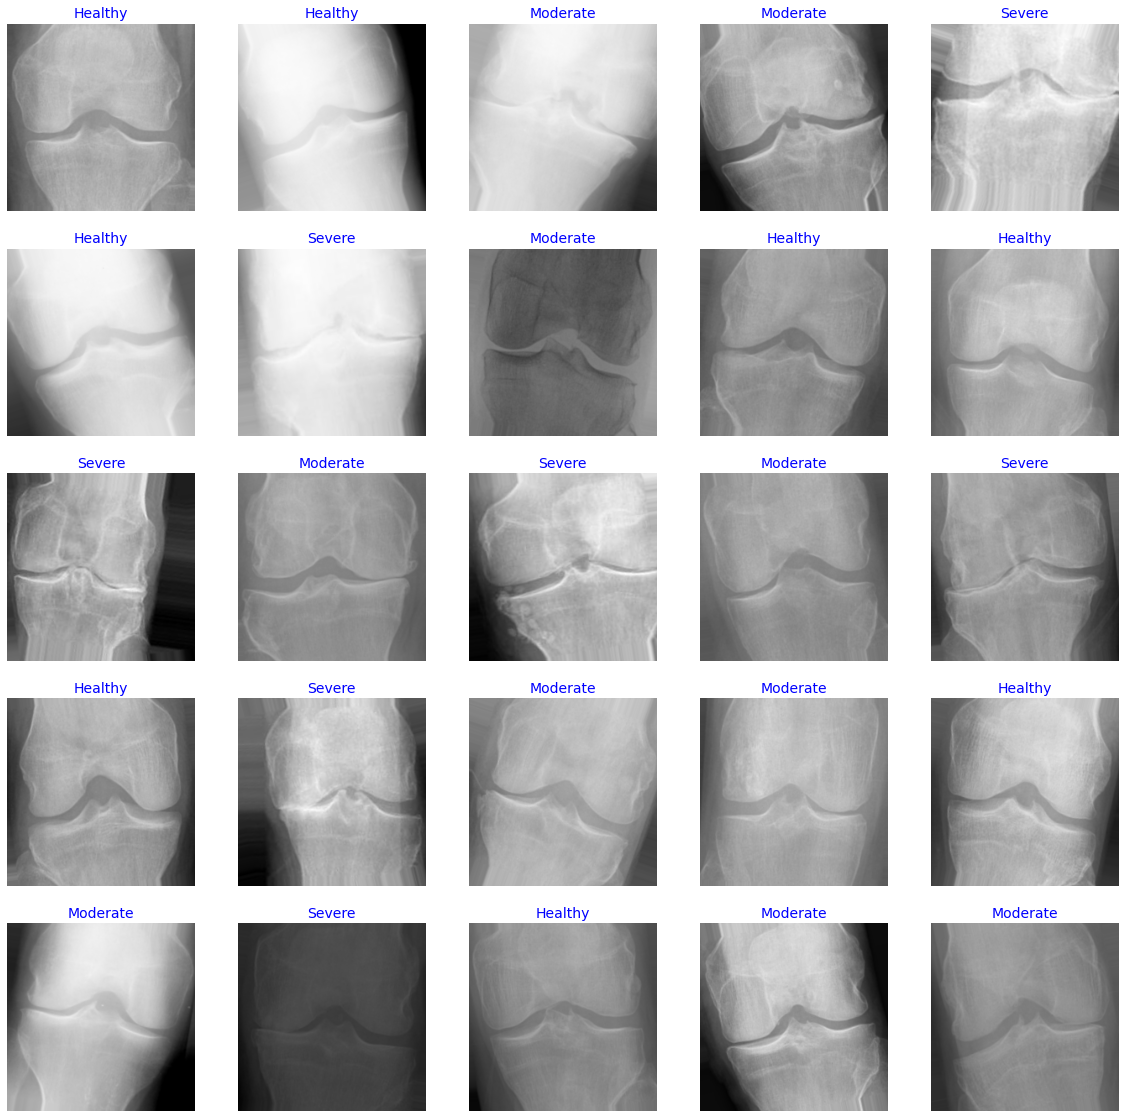

In [10]:
def show_image_samples(gen ):
    t_dict=gen.class_indices
    classes=list(t_dict.keys())    
    images,labels=next(gen) # get a sample batch from the generator 
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):        
        plt.subplot(5, 5, i + 1)
        image=images[i] /255       
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=14)
        plt.axis('off')
    plt.show()
    
show_image_samples(train_gen )

<a id="model"></a>
# <center>Creating the model</center>

In [11]:
# Clear the session
K.clear_session()
tf.compat.v1.reset_default_graph()

# Define image shape
img_shape = (img_size[0], img_size[1], 3)

# Load EfficientNetB5 base model
base_model = tf.keras.applications.EfficientNetB5(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')

# Make the base model trainable
base_model.trainable = True

# Add custom layers on top of the base model
x = base_model.output
x = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(x)
x = Dense(256, kernel_regularizer=regularizers.l2(0.016), 
          activity_regularizer=regularizers.l1(0.006), 
          bias_regularizer=regularizers.l1(0.006), activation='relu')(x)
x = Dropout(rate=0.4, seed=123)(x)
output = Dense(class_count, activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
lr = 0.001  # Starting learning rate
model.compile(optimizer=Adamax(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])

115277824/115263384 [==============================] - 1s 0us/step


In [12]:
epochs = 40
ask_epoch = 10
ask = LR_ASK(epochs, ask_epoch)
callbacks = [ask]

<a id="train"></a>
# <center>Training the Model</center>

Change LR to 0.005 after 10 epochs and run 10 more epochs

In [13]:
history = model.fit(
    x=train_gen,
    epochs=epochs,
    verbose=1,
    callbacks=callbacks,
    validation_data=valid_gen,
    validation_steps=None,
    shuffle=False,
    initial_epoch=0,
)

Training will proceed until epoch 10, then you will be asked to continue or halt.
Epoch 1/40
47/47 [==============================] - 68s 836ms/step - loss: 8.4060 - accuracy: 0.6447 - val_loss: 7.8501 - val_accuracy: 0.7809

Validation loss of 7.8501 is below lowest loss, saving weights from epoch 1 as best weights
Epoch 2/40
47/47 [==============================] - 34s 715ms/step - loss: 6.7761 - accuracy: 0.7927 - val_loss: 6.1920 - val_accuracy: 0.8612

Validation loss of 6.1920 is below lowest loss, saving weights from epoch 2 as best weights
Epoch 3/40
47/47 [==============================] - 34s 714ms/step - loss: 5.5318 - accuracy: 0.8880 - val_loss: 5.1682 - val_accuracy: 0.9067

Validation loss of 5.1682 is below lowest loss, saving weights from epoch 3 as best weights
Epoch 4/40
47/47 [==============================] - 34s 712ms/step - loss: 4.6917 - accuracy: 0.9107 - val_loss: 4.5182 - val_accuracy: 0.8677

Validation loss of 4.5182 is below lowest loss, saving weights fro

 10


Training will continue to epoch 20
Current LR is 0.00100. Press enter to keep this LR or enter a new LR:


 0.005


Changing LR to 0.005
Epoch 11/40
47/47 [==============================] - 34s 712ms/step - loss: 1.8248 - accuracy: 0.9020 - val_loss: 1.7717 - val_accuracy: 0.8482

Validation loss of 1.7717 is below lowest loss, saving weights from epoch 11 as best weights
Epoch 12/40
47/47 [==============================] - 34s 712ms/step - loss: 1.2904 - accuracy: 0.9007 - val_loss: 3.6303 - val_accuracy: 0.3601

Validation loss of 3.6303 is above lowest loss of 1.7717, keeping weights from epoch 11 as best weights
Epoch 13/40
47/47 [==============================] - 34s 712ms/step - loss: 0.8914 - accuracy: 0.9180 - val_loss: 2.1467 - val_accuracy: 0.7267

Validation loss of 2.1467 is above lowest loss of 1.7717, keeping weights from epoch 11 as best weights
Epoch 14/40
47/47 [==============================] - 34s 712ms/step - loss: 0.6748 - accuracy: 0.9313 - val_loss: 1.0293 - val_accuracy: 0.8286

Validation loss of 1.0293 is below lowest loss, saving weights from epoch 14 as best weights
Epoch

 H


Training halted on epoch 20 due to user input

Loading model with weights from epoch 17
Training elapsed time was 0 hours, 18 minutes, 59 seconds


<a id="plot"></a>
# <center>Defining a function to plot the training data</center>

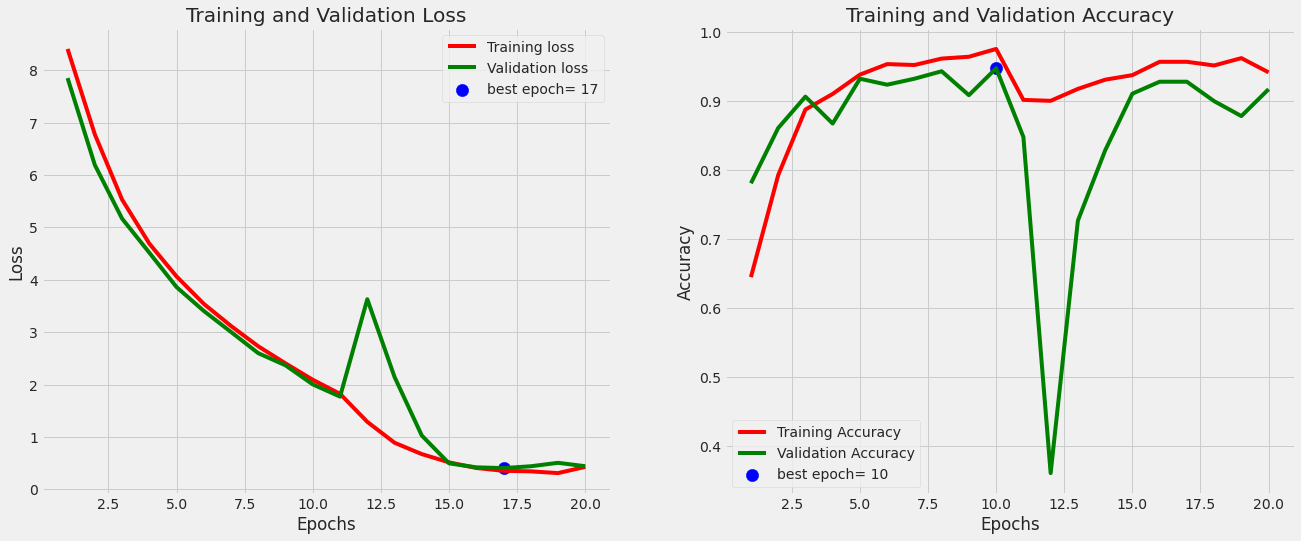

In [14]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout    
    plt.show()
    
tr_plot(history,0)

<a id="result"></a>
# <center>Making predictions on test set, creating Confusion Matrix and Classification Report</center>

83/83 [==============================] - 9s 69ms/step
there were 41 errors in 913 tests for an accuracy of  95.51


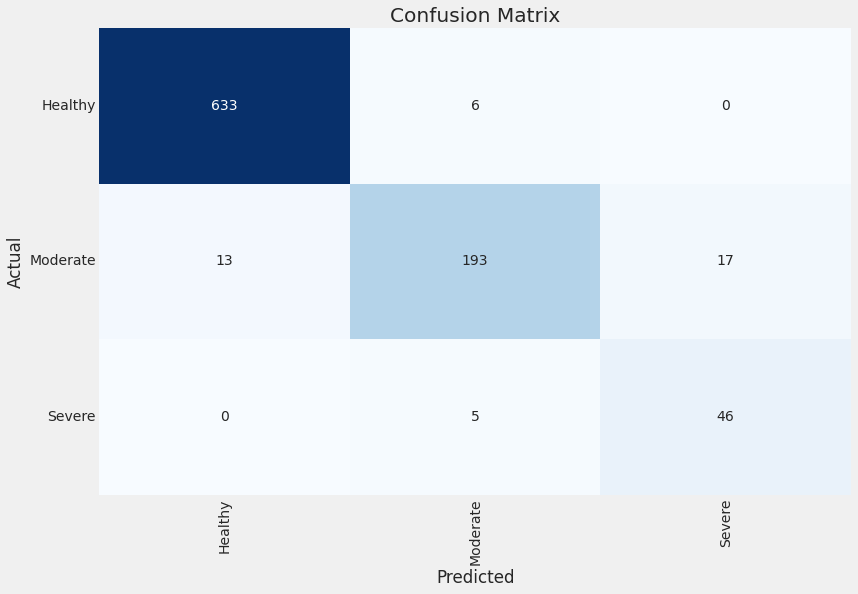

Classification Report:
----------------------
               precision    recall  f1-score   support

     Healthy     0.9799    0.9906    0.9852       639
    Moderate     0.9461    0.8655    0.9040       223
      Severe     0.7302    0.9020    0.8070        51

    accuracy                         0.9551       913
   macro avg     0.8854    0.9193    0.8987       913
weighted avg     0.9577    0.9551    0.9554       913



In [15]:
def predictor(test_gen, test_steps):
    y_pred= []
    y_true=test_gen.labels
    classes=list(test_gen.class_indices.keys())
    class_count=len(classes)
    errors=0
    preds=model.predict(test_gen, verbose=1)
    tests=len(preds)
    for i, p in enumerate(preds):
        pred_index=np.argmax(p)
        true_index=test_gen.labels[i]  # labels are integer values
        if pred_index != true_index: # a misclassification has occurred
            errors=errors + 1
            file=test_gen.filenames[i]
        y_pred.append(pred_index)

    acc=( 1-errors/tests) * 100
    print(f'there were {errors} errors in {tests} tests for an accuracy of {acc:6.2f}')
    ypred=np.array(y_pred)
    ytrue=np.array(y_true)
    if class_count <=30:
        cm = confusion_matrix(ytrue, ypred )
        # plot the confusion matrix
        plt.figure(figsize=(12, 8))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
        plt.xticks(np.arange(class_count)+.5, classes, rotation=90)
        plt.yticks(np.arange(class_count)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes, digits= 4) # create classification report
    print("Classification Report:\n----------------------\n", clr)
    return errors, tests
errors, tests=predictor(test_gen, test_steps)

<a id="save"></a>
# <center>Saving the Model </center>

In [27]:
subject='kneeosteoarthritis' 
acc=str(( 1-errors/tests) * 1000)
index=acc.rfind('.')
acc=acc[:index + 3]
save_id= subject + '_' + str(acc) + '.h5' 
model_save_loc=os.path.join(working_dir, save_id)
model.save(model_save_loc)
print ('model was saved as ' , model_save_loc )

model was saved as  ./kneeosteoarthritis_955.09.h5


<a id="single"></a>
# <center>Model Application Test</center>

In [28]:
# Step 1: Imports and Setup

import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.models import load_model
from IPython.display import Image, display

In [29]:
# Step 2: Load and Preprocess Image

def load_and_preprocess_image(image_path, target_size=(224, 224)):
    # Load image using OpenCV
    img = cv2.imread(image_path)
    
    # Resize image to target size
    img = cv2.resize(img, target_size)
    
    # Convert BGR image to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Convert image to array and preprocess for EfficientNet
    img_array = img.astype(np.float32)
    img_array = preprocess_input(img_array)
    
    return img_array

In [30]:
# Step 3: Generate Predictions

def predict_single_image(image_path):
    img = load_and_preprocess_image(image_path)  
    img = np.expand_dims(img, axis=0)  
    pred = model.predict(img)  
    pred_index = np.argmax(pred)
    confidence = np.max(pred)  # Get the confidence of the predicted class
    return pred_index, confidence

In [31]:
# Step 4: Generate Output Image

def display_image_with_prediction(image_path):
  predicted_class, confidence = predict_single_image(image_path)
  img = cv2.imread(image_path) 
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  plt.imshow(img)
  plt.title(f"Prediction: {classes[predicted_class]} ({confidence * 100:.2f}%)")
  plt.axis('off') 
  plt.show()

  # Additional text output
  print(f"Detailed Analysis: The image is predicted to be in the '{classes[predicted_class]}' category with {confidence * 100:.2f}% confidence.")
  if predicted_class == 0:
    print("In healthy knees, the cartilage is intact, and there are no signs of wear or joint space narrowing. Individuals in this category typically experience no pain and maintain full mobility.")
  elif predicted_class == 1:
    print("Moderate OA is characterized by noticeable cartilage damage and joint space narrowing, often leading to pain, stiffness, and reduced function. This stage may require interventions such as physical therapy, weight management, or anti-inflammatory medications to alleviate symptoms and slow progression.")
  elif predicted_class == 2:
    print("Severe OA presents with significant cartilage loss, bone spurs, and possible joint deformity. Pain is often chronic and debilitating, severely limiting mobility. Future steps may include advanced treatments like viscosupplementation, cortisone injections, or surgical options such as total knee replacement to restore function and improve quality of life. Early detection and consistent management are key to mitigating progression at all stages.")
 

In [32]:
# Step 3: Load Pre-trained CNN Model

model = load_model(model_save_loc)
print('Model loaded from', model_save_loc)

Model loaded from ./kneeosteoarthritis_955.09.h5


In [33]:
# Step 6: Define the classes 

list_of_classes

['Healthy', 'Moderate', 'Severe']

In [48]:
# Step 7: Upload Image

import ipywidgets as widgets
from IPython.display import display

uploader = widgets.FileUpload()
display(uploader)

def handle_upload(change):
    uploaded_filename = next(iter(uploader.value))
    content = uploader.value[uploaded_filename]['content']
    with open('uploaded_image.jpg', 'wb') as f:  # Save uploaded image
        f.write(content)

uploader.observe(handle_upload, names='value')

FileUpload(value={}, description='Upload')

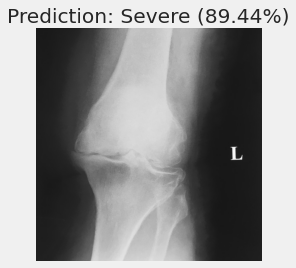

Detailed Analysis: The image is predicted to be in the 'Severe' category with 89.44% confidence.
Severe OA presents with significant cartilage loss, bone spurs, and possible joint deformity. Pain is often chronic and debilitating, severely limiting mobility. Future steps may include advanced treatments like viscosupplementation, cortisone injections, or surgical options such as total knee replacement to restore function and improve quality of life. Early detection and consistent management are key to mitigating progression at all stages.


In [49]:
# Step 8: Show Results from Uploaded Image

display_image_with_prediction('uploaded_image.jpg')  # Use your existing function

#Image is used from outside the Dataset